In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
from glob import glob

In [2]:
ds = xr.Dataset(coords={'time': ('time', np.arange(3000)*3600.)})
ds = ds.assign(u=np.cos(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
ds = ds.assign(v=np.sin(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Data variables:
    u        (time) float64 1.082 0.5735 1.721 0.4668 -0.8906 -0.1221 ...
    v        (time) float64 -0.498 -0.263 0.559 0.7792 0.1973 0.1934 0.4387 ...


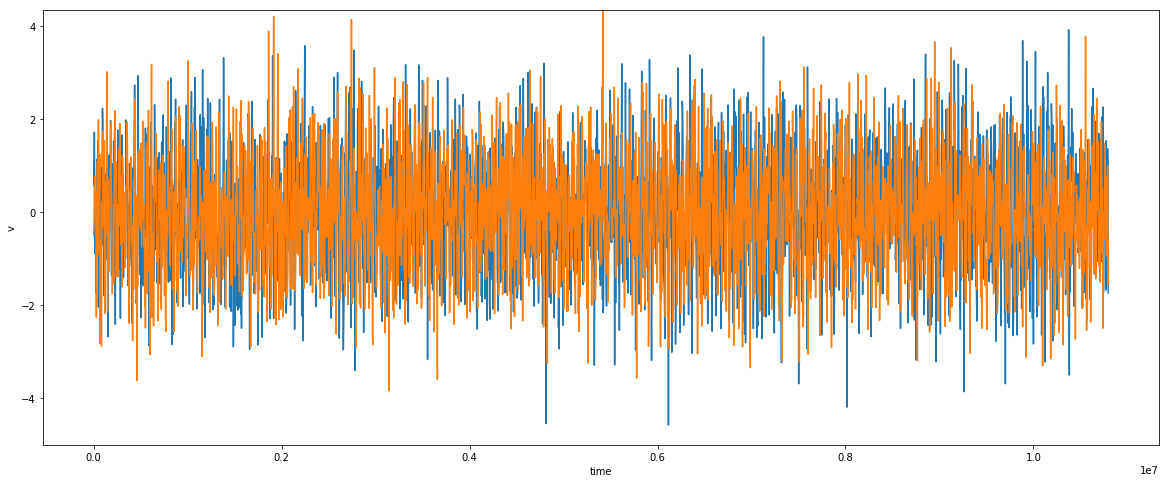

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
ds['u'].plot()
ds['v'].plot()

# Normal FFT

In [4]:
%time uv_complex = (ds['u'] + 1j*ds['v'])
print(uv_complex)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.82 ms
<xarray.DataArray (time: 3000)>
array([ 1.082365-0.498001j,  0.573477-0.262988j,  1.721184+0.559023j, ...,
        1.364746+1.001644j,  1.033036-1.555693j, -1.732105-0.56426j ])
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...


In [5]:
uv_fft = xrft.dft(uv_complex.fillna(0.), shift=False, detrend='linear')
E_uv = (uv_fft*uv_fft.conj()).where(uv_fft!=0., drop=False)
print(E_uv)
E_uv = E_uv.astype('f8').rename('uv_power_spectrum ()')

<xarray.DataArray (freq_time: 3000)>
array([9.570461e-27+0.j, 1.276151e+04+0.j, 1.353596e+04+0.j, ...,
       2.172954e+03+0.j, 3.246580e+02+0.j, 1.271575e+04+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


(10.0, 1000000.0)

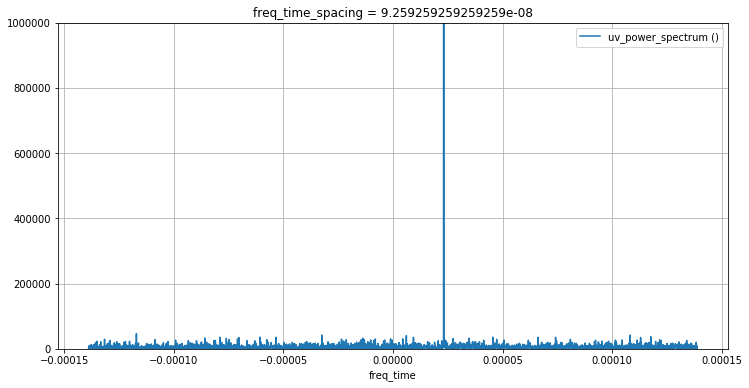

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

E_uv.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_ylabel(''); 
ax.set_ylim([1e1,1e6])

# Averaging 

In [7]:
E_dir = '/home1/scratch/xyu/mit_spec/E_uv_test/'

nfft = 300
noverlap = nfft/2
window = np.hanning(nfft)

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))
print(T)

[   0  150  300  450  600  750  900 1050 1200 1350 1500 1650 1800 1950
 2100 2250 2400 2550 2700]


In [9]:
for t in T:
        
    uv_complex = (ds['u'].isel(time=slice(t,t+nfft)) + 1j*ds['v'].isel(time=slice(t,t+nfft)))    
    
    uv_fft_complex = xrft.dft(uv_complex.fillna(0.), shift=False, detrend='linear', window=True)
    E_uv = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)
    E_uv = np.real(E_uv).rename('E_uv')
    file_E = E_dir+'E_uv_t%04d.nc'%t 
    E_uv.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [10]:
filenames = sorted(glob(E_dir+'E_uv_t*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='blocks', compat='equals')
print(ds)

CPU times: user 60 ms, sys: 16 ms, total: 76 ms
Wall time: 83.5 ms
<xarray.Dataset>
Dimensions:            (blocks: 19, freq_time: 300)
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07
Dimensions without coordinates: blocks
Data variables:
    E_uv               (blocks, freq_time) float64 dask.array<shape=(19, 300), chunksize=(1, 300)>


In [12]:
E = (ds.E_uv).mean(dim='blocks')
print(E)

<xarray.DataArray 'E_uv' (freq_time: 300)>
dask.array<shape=(300,), dtype=float64, chunksize=(300,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07


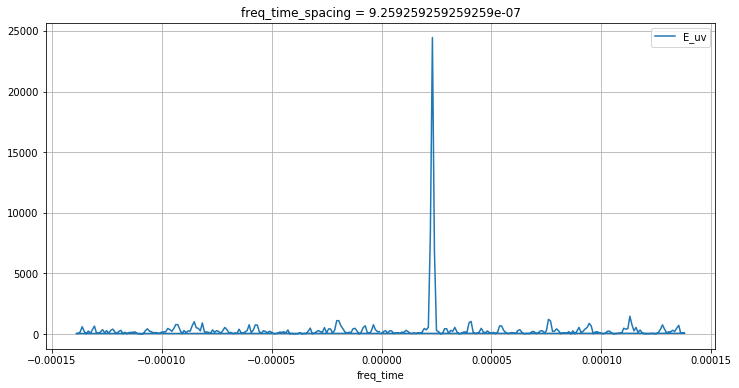

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

E_uv.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_ylabel(''); 
#ax.set_ylim([1e1,1e6])


